# Quantum Teleportation

Importing the required tools from libraries -

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random

Let us first create the circuit that implements the Teleportation protocol. Note that it consists of the qubit that is to be transported, 1 ebit (composed of two entangled qubits in state $|+\rangle$), and 2 classsical bits a and b.

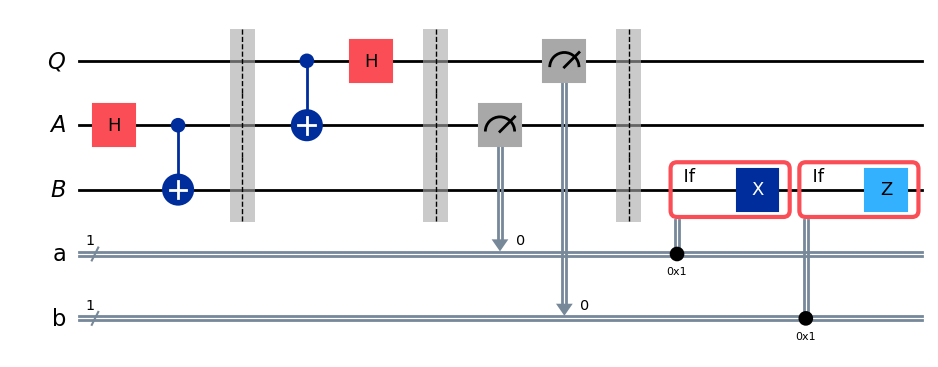

In [17]:
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

# Alice's operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

# Bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

display(protocol.draw(output="mpl"))

Now, in order to test the circuit, we want to send random input qubits into Q. To achieve this, we construct a random gate that will first act on the $|0\rangle$ state, and its output will be sent to Q in the circuit above. Then we will operate the inverse gate on the output qubit B of the Teleportation circuit, and then measure it. If the Teleportation circuit works, we should get the pure $|0\rangle$ state at the output, i.e., the measurement should output 0 with 100% probability.

In [15]:
# Constructing the random gate to act on 0 state
random_gate = UGate(
    theta=random.random() * 2 * pi,
    phi=random.random() * 2 * pi,
    lam=random.random() * 2 * pi
)

display(array_to_latex(random_gate.to_matrix()))

<IPython.core.display.Latex object>

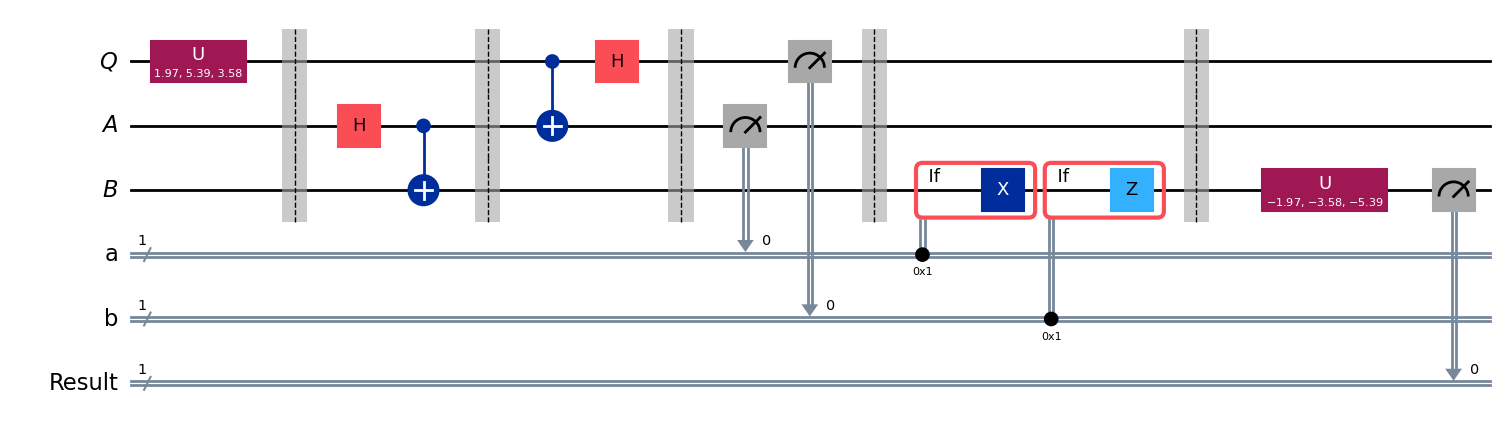

In [12]:
# Create a new circuit including the same bits and qubits used in the
# teleportation protocol.

test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Start with the randomly selected gate on Q

test.append(random_gate, qubit)
test.barrier()

# Append the entire teleportation protocol from above.

test = test.compose(protocol)
test.barrier()

# Finally, apply the inverse of the random unitary to B and measure.

test.append(random_gate.inverse(), ebit1)
result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

display(test.draw(output="mpl"))

Now, we can test our Teleportation circuit by testing it with our random gate multiple times.

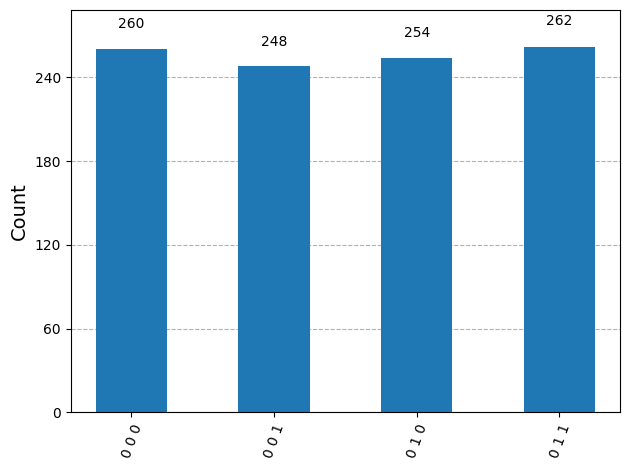

In [13]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

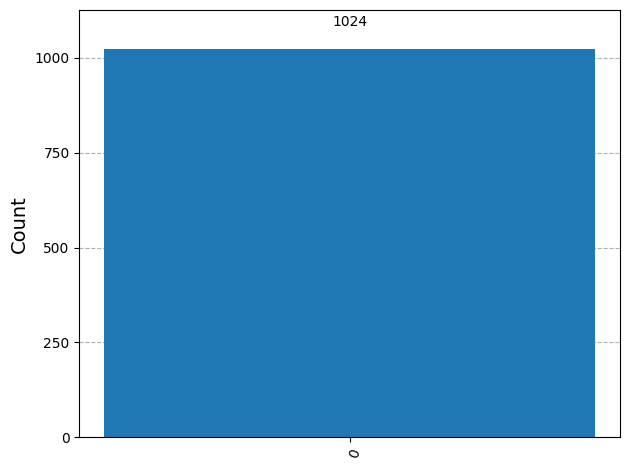

In [16]:
filtered_statistics = marginal_distribution(statistics, [2])
display(plot_histogram(filtered_statistics))

We notice that the output is 0 in all test cases. Hence, the teleportation circuit is working properly!